In [4]:
# 3rd party
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lightkurve as lk
from collections import defaultdict
import textwrap
import logging

In [5]:
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)s - %(message)s')

logger = logging.getLogger(__name__) 



In [6]:
logger.info("test")

INFO - test


In [388]:
plot_dir = Path(f"/Users/jochoa4/Desktop/studies/study_model_preds_07-16-2025")
plot_dir.mkdir(parents=True, exist_ok=True)

tce_tbl_fp = Path(
    "/Users/jochoa4/Projects/exoplanet_transit_classification/ephemeris_tables/preprocessing_tce_tables/tess_2min_tces_dv_s1-s68_all_msectors_11-29-2023_2157_newlabels_nebs_npcs_bds_ebsntps_to_unks.csv"
)

scores_tbls_dir = Path(
    "/Users/jochoa4/Desktop/pfe_transfers/predict_model_TESS_exoplanet_dataset_07-11-2025_no_ntp_no_detrend_split_norm_filtered"
)

show_plots = False
# -------------------- Load Data --------------------
tce_tbl = pd.read_csv(tce_tbl_fp)
tce_tbl = tce_tbl.rename(columns={"uid": "tce_uid", "label": "disposition"})

if 'target_id' not in tce_tbl.columns:
    logger.debug("target_id not in tce_tbl, adding it")
    tce_tbl['target_id'] = (
        tce_tbl['tce_uid'].astype(str)
               .str.split('-')
               .str[0]
               .astype(int)
    )
# -------------------- Helper Functions --------------------
def _get_confusion_label(row):
    label, pred_label = row['label'], row['pred_label']
    if label == 0 and pred_label == 0:
        return 'TN'
    if label == 0 and pred_label == 1:
        return 'FP'
    if label == 1 and pred_label == 0:
        return 'FN'
    if label == 1 and pred_label == 1:
        return 'TP'
    return 'UNKNOWN'

# -------------------- Mixed-Target Flag --------------------
mixed_targets = {
    tid for tid, grp in tce_tbl.groupby('target_id')
    if grp['disposition'].isin(['EB','CP','KP']).any()
    and grp['disposition'].isin(['NTP','NEB','NPC']).any()
}


tce_tbl_cols = list(tce_tbl.columns)
log_features = ['tce_depth', 'tce_max_mult_ev', 'tce_maxmes', 'tce_period', 'tce_duration', 'tce_num_transits', 'tce_dikco_msky_original', 'tce_dikco_msky_err_original', 'tce_dicco_msky_original','tce_dicco_msky_err_original']
linear_features = []
feature_cols = log_features + linear_features
feature_cols = [f for f in feature_cols if f in tce_tbl_cols]

summary_rows = []

all_preds_tbl = []
for split_name in ['train', 'val', 'test']:
    preds_tbl = preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
    preds_tbl = pd.read_csv(preds_tbl_fp)
     # Extract identifiers and flags
    preds_tbl['tce_uid'] = preds_tbl['uid'].str.split('_').str[0]
    preds_tbl['target_id'] = preds_tbl['tce_uid'].str.split('-').str[0].astype(int)
    preds_tbl['confusion'] = preds_tbl.apply(_get_confusion_label, axis=1)
    preds_tbl['mixed_target_flag'] = preds_tbl['target_id'].apply(lambda t: 1 if t in mixed_targets else 0)

    merge_cols = ['tce_uid'] + feature_cols
    preds_tbl = preds_tbl.merge(
        tce_tbl[merge_cols],
        on="tce_uid",
        how="left",
        validate="many_to_one",
    )

    preds_tbl['split'] = split_name
    all_preds_tbl.append(preds_tbl)
all_preds_tbl = pd.concat(all_preds_tbl)

for split_name in ['train', 'val', 'test']:
    split_plot_dir = plot_dir / split_name
    split_plot_dir.mkdir(parents=True, exist_ok=True)

    # Load predictions
    # preds_tbl_fp = scores_tbls_dir / f"preds_{split_name}.csv"
    # preds_tbl = pd.read_csv(preds_tbl_fp)
    preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split_name].copy()

    logger.info(f"\n=== Split: {split_name} ===")
    split_dir = plot_dir / split_name
    split_dir.mkdir(exist_ok=True)

   


    # Summaries
    logger.info(f"Total examples: {len(preds_tbl)}")
    logger.info(f"Confusion counts:\n{preds_tbl['confusion'].value_counts()}" )

    # Build CF df
    for cf, df_cf in preds_tbl.groupby("confusion"):
        summary_rows.append({
            "split":      split_name,
            "disposition": "ANY",
            "confusion":  cf,
            "count":      len(df_cf)
        })

    # per‐disposition confusion counts
    for disp, df_disp in preds_tbl.groupby("disposition"):
        for cf, df_cf in df_disp.groupby("confusion"):
            summary_rows.append({
                "split":       split_name,
                "disposition": disp,
                "confusion":   cf,
                "count":       len(df_cf)
            })

    for disp in preds_tbl['disposition'].unique():
        df_disp = preds_tbl[preds_tbl['disposition'] == disp]
        logger.info(f"\n{disp} ({len(df_disp)} examples)")
        logger.info(df_disp['confusion'].value_counts().to_string())
        logger.info(df_disp[feature_cols].describe().to_string())

    for label_key in ['tw_flag']:
        
        bins_scores = np.linspace(0, 1, 11)

        for disp in preds_tbl["disposition"].unique():
            preds_tbl_disp = preds_tbl.loc[preds_tbl["disposition"] == disp]

            transit_window_examples = preds_tbl_disp.loc[preds_tbl_disp[label_key] == 1]
            not_transit_window_examples = preds_tbl_disp.loc[preds_tbl_disp[label_key] == 0]

            f, ax = plt.subplots()

            if len(transit_window_examples) > 0:
                ax.hist(
                    transit_window_examples["pred_prob"],
                    bins_scores,
                    histtype="step",
                    label="Transit Windows" if label_key == "tw_flag" else "Positive Label Examples",
                    zorder=2,
                    linestyle="dashed",
                    color="#1f77b4",
                )
            if len(not_transit_window_examples) > 0:
                ax.hist(
                    not_transit_window_examples["pred_prob"],
                    bins_scores,
                    histtype="step",
                    label="Not-Transit Windows" if label_key == "tw_flag" else "Negative Label Examples",
                    zorder=1,
                    color="#ff7f0e",
                )

            ax.set_ylabel("Example Count")
            ax.set_xlabel("Model Score")
            ax.set_yscale("log")
            ax.set_title(f"{disp}")
            ax.legend()
            ax.set_xlim(bins_scores[[0, -1]])
            f.savefig(split_plot_dir / f"hist_model_scores_{disp}.png")
            if show_plots:
                plt.show()
            else:
                plt.close()
        

        for feature_col in feature_cols:
            # 1) Floor tiny values for log‐scale features
            if feature_col in log_features:
                pos_min = preds_tbl.loc[preds_tbl[feature_col] > 0, feature_col].min()
                eps_threshold = max(0.1, 0.1 * pos_min)
                n_round = (preds_tbl[feature_col] < eps_threshold).sum()
                if n_round:
                    logger.warning(f"Rounding {n_round} values of {feature_col} < {eps_threshold} up to {eps_threshold}")
                preds_tbl[feature_col] = preds_tbl[feature_col].clip(lower=eps_threshold)

            # 2) Compute finite min/max for bins and axis limits
            min_val = preds_tbl[feature_col].min()
            max_val = preds_tbl[feature_col].max()
            left_lim, right_lim = min_val, max_val

            # 3) Build bins depending on scale
            if feature_col in log_features:
                bins_feature = np.logspace(np.log10(left_lim), np.log10(right_lim), 50)
            else:
                bins_feature = np.linspace(left_lim, right_lim, 50)

            # 4) Compute median TCE‐level model scores
            med_tce_score = (
                preds_tbl[["tce_uid", "pred_prob", label_key]]
                .groupby(["tce_uid", label_key])
                .median()
                .reset_index()
            ).merge(
                tce_tbl[["tce_uid", "disposition", feature_col]],
                how="left",
                on="tce_uid",
                validate="many_to_one",
            )

            # 5) Plot per‐example hist2d and count/dismiss NaNs or Infs
            for disp in preds_tbl["disposition"].unique():
                for label in preds_tbl[label_key].unique():
                    preds_tbl_disp = preds_tbl.loc[
                        (preds_tbl["disposition"] == disp) &
                        (preds_tbl[label_key]      == label),
                        [feature_col, "pred_prob"]
                    ]

                    if preds_tbl_disp.empty:
                        continue

                    # Count NaN or infinite rows
                    mask_bad = (~np.isfinite(preds_tbl_disp)).any(axis=1)
                    n_bad = mask_bad.sum()
                    if n_bad:
                        logger.warning(f"Dropping {n_bad} rows from {disp}, label={label} with NaN/Inf in {feature_col} or pred_prob")
                    preds_tbl_disp = preds_tbl_disp.loc[~mask_bad]
                    if preds_tbl_disp.empty:
                        continue

                    # Generic 2D histogram
                    f, ax = plt.subplots()
                    hist_kwargs = dict(
                        x=preds_tbl_disp[feature_col],
                        y=preds_tbl_disp["pred_prob"],
                        bins=[bins_feature, bins_scores],
                        cmap="jet",
                        norm=LogNorm() if feature_col in log_features else None
                    )
                    im = ax.hist2d(**{k: v for k, v in hist_kwargs.items() if v is not None})[3] if feature_col in log_features else ax.hist2d(**hist_kwargs)[3]

                    ax.set_ylim(0, 1)
                    ax.set_xlim(left_lim, right_lim)
                    if feature_col in log_features:
                        ax.set_xscale("log")

                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im, cax=cax, label="Example Count")

                    ax.set_ylabel("Model Score")
                    ax.set_xlabel(f"TCE {feature_col.replace('tce_', '')}")
                    ax.set_title(f"Disposition {disp} | {'Transit Window Flag' if label_key=='tw_flag' else 'Label'} {label}")
                    f.savefig(split_plot_dir / f"hist2d_model_scores_{feature_col}_{disp}_{label}.png")
                    if show_plots:
                        plt.show()
                    else:
                        plt.close()

            # 6) Plot median‐score hist2d
            for disp in med_tce_score["disposition"].unique():
                for label in med_tce_score[label_key].unique():
                    med_disp = med_tce_score.loc[
                        (med_tce_score["disposition"] == disp) &
                        (med_tce_score[label_key]      == label),
                        [feature_col, "pred_prob"]
                    ]
                    if med_disp.empty:
                        continue

                    # Count NaN or infinite rows
                    mask_bad = (~np.isfinite(med_disp)).any(axis=1)
                    n_bad = mask_bad.sum()
                    if n_bad:
                        logger.warning(f"Dropping {n_bad} median rows from {disp}, label={label} with NaN/Inf in {feature_col} or pred_prob")
                    med_disp = med_disp.loc[~mask_bad]
                    if med_disp.empty:
                        continue

                    f, ax = plt.subplots()
                    hist_kwargs = dict(
                        x=med_disp[feature_col],
                        y=med_disp["pred_prob"],
                        bins=[bins_feature, bins_scores],
                        cmap="jet",
                        norm=LogNorm() if feature_col in log_features else None,
                    )
                    im = ax.hist2d(**{k: v for k, v in hist_kwargs.items() if v is not None})[3] if feature_col in log_features else ax.hist2d(**hist_kwargs)[3]

                    ax.set_ylim(0, 1)
                    ax.set_xlim(left_lim, right_lim)
                    if feature_col in log_features:
                        ax.set_xscale("log")

                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    plt.colorbar(im, cax=cax, label="TCE Count")

                    ax.set_ylabel("TCE Median Model Score")
                    ax.set_xlabel(f"TCE {feature_col.replace('tce_', '')}")
                    ax.set_title(f"Disposition {disp} | {'Transit Window Flag' if label_key=='tw_flag' else 'Label'} {label}")
                    f.savefig(split_plot_dir / f"hist2d_model_scores_{feature_col}_median_{disp}_{label}.png")
                    if show_plots:
                        plt.show()
                    else:
                        plt.close()
                    
            logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
            logger.info(preds_tbl['confusion'].value_counts())

        for disp in preds_tbl['disposition'].unique():
            logger.info(f"{disp} Summary")
            disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
            print(f"{split_name} set consists of {len(disp_preds_tbl)} {disp} examples.")
            print(disp_preds_tbl['confusion'].value_counts())
            
        worst_examples = {
            cf : defaultdict(list) for cf in preds_tbl["confusion"].unique()
        }

        for cf in ['FP', 'FP']:
            worst_examples[cf] = preds_tbl[preds_tbl["confusion"] == cf]

            worst_targets_set = set([])
            worst_targets_list = []
            worst_targets_map = defaultdict(list)
            for _, cf_data in worst_examples[cf].iterrows():
                worst_targets_set.add(cf_data['target_id'])
                worst_targets_list.append(cf_data['target_id'])
                worst_targets_map[cf_data['target_id']].append(cf_data['uid'])

            for t, exs in worst_targets_map.items():
                logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")

        # num_examples = 200
        # # Get most confident FP/TN predictions
        # fp_df = preds_tbl[preds_tbl["confusion"] == "FP"]
        # worst_examples["FP"] = fp_df.nlargest(num_examples, columns=["pred_prob"])

        # tn_df = preds_tbl[preds_tbl["confusion"] == "TN"]
        # worst_examples["TN"] = tn_df.nlargest(num_examples, columns=["pred_prob"])

        # # Get least confident TP/FN predictions
        # tp_df = preds_tbl[preds_tbl["confusion"] == "TP"]
        # worst_examples["TP"] = tp_df.nsmallest(num_examples, columns=["pred_prob"])

        # fn_df = preds_tbl[preds_tbl["confusion"] == "FN"]
        # worst_examples["FN"] = fn_df.nsmallest(num_examples, columns=["pred_prob"])

        # worst_targets_set = set([])
        # worst_targets_list = []
        # worst_targets_map = defaultdict(list)
        # for _, fn in worst_examples["FN"].iterrows():
        #     logger.info(f"{fn['target']}, {fn['uid']}, {fn['pred_prob']}")
        #     worst_targets_set.add(fn['target'])
        #     worst_targets_list.append(fn['target'])
        #     worst_targets_map[fn['target']].append(fn['uid'])

        # for t, exs in worst_targets_map.items():
        #     logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")import pandas as pd

summary_df = pd.DataFrame(summary_rows)
logger.info(summary_df.to_string(index=False))


/var/folders/_z/srkh35f94rd_6jrkc3kv29hm0000gp/T/ipykernel_49323/2520902902.py:14: DtypeWarning: Columns (364,366,367,370,371) have mixed types. Specify dtype option on import or set low_memory=False.
  tce_tbl = pd.read_csv(tce_tbl_fp)
INFO - 
=== Split: train ===
INFO - Total examples: 207557
INFO - Confusion counts:
confusion
TP    173003
TN     33964
FN       575
FP        15
Name: count, dtype: int64
INFO - 
CP (14148 examples)
INFO - confusion
TN    13239
TP      733
FN      165
FP       11
INFO -            tce_depth  tce_max_mult_ev    tce_maxmes    tce_period  tce_duration  tce_num_transits  tce_dikco_msky_original  tce_dikco_msky_err_original  tce_dicco_msky_original  tce_dicco_msky_err_original
count   14148.000000     14148.000000  14148.000000  14148.000000  14148.000000      14148.000000             14148.000000                 14148.000000             14148.000000                 14148.000000
mean    55759.697478        35.717691      2.720668      5.544775      1.856815

train set consists of 14148 CP examples.
confusion
TN    13239
TP      733
FN      165
FP       11
Name: count, dtype: int64
train set consists of 183443 EB examples.
confusion
TP    172202
TN     10845
FN       392
FP         4
Name: count, dtype: int64
train set consists of 9966 KP examples.
confusion
TN    9880
TP      68
FN      18
Name: count, dtype: int64


WARNING - Rounding 30 values of tce_depth < 24.6346522973042 up to 24.6346522973042
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
WARNING - Rounding 31 values of tce_maxmes < 0.1 up to 0.1
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
WARNING - Rounding 6435 values of tce_num_transits < 0.2 up to 0.2
INFO - val set consists of 13868 examples.
INFO - confusion
TP    9832
TN    3966
FN      68
FP       2
Name: count, dtype: int64
WARNING - 

val set consists of 11135 EB examples.
confusion
TP    9828
TN    1284
FN      21
FP       2
Name: count, dtype: int64
val set consists of 1571 CP examples.
confusion
TN    1571
Name: count, dtype: int64
val set consists of 1162 KP examples.
confusion
TN    1111
FN      47
TP       4
Name: count, dtype: int64


WARNING - Rounding 17 values of tce_depth < 17.879255639011415 up to 17.879255639011415
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
WARNING - Rounding 12192 values of tce_num_transits < 0.2 up to 0.2
INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
WARNING - Rounding 1391 values of 

test set consists of 20250 EB examples.
confusion
TP    18877
TN     1360
FN       12
FP        1
Name: count, dtype: int64
test set consists of 1088 CP examples.
confusion
TN    1088
Name: count, dtype: int64
test set consists of 1143 KP examples.
confusion
TN    1143
Name: count, dtype: int64


In [ ]:
train_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == 'train']
train_preds_tbl[(train_preds_tbl['tce_dikco_msky'] > 20.0)]['tce_uid']

78352        453828065-1-S4
78415        89787749-1-S64
78497         89787749-1-S8
78759        89787749-1-S64
79373        89787749-1-S64
                ...        
197248    443616612-2-S1-65
199142    443616612-2-S1-65
200907       89787749-1-S64
203758    443616612-2-S1-65
204189    443616612-2-S1-65
Name: tce_uid, Length: 98, dtype: object

In [ ]:
for col in tce_tbl.columns:
    if 'FP' in list(tce_tbl[col]):
        print(f'col: {col}')


In [127]:
for col in tce_tbl.columns:
    if 'dikco' in col:
        print(col)

tce_dikco_msky
tce_dikco_msky_err
tce_dikco_msky_adjscl
tce_dikco_msky_err_adjscl
tce_dikco_msky_original
tce_dikco_msky_err_original


In [139]:
abs(all_preds_tbl['pred_prob'] - all_preds_tbl['label'])

0        1.419091e-06
1        0.000000e+00
2        0.000000e+00
3        0.000000e+00
4        0.000000e+00
             ...     
22476    0.000000e+00
22477    0.000000e+00
22478    0.000000e+00
22479    9.052135e-08
22480    0.000000e+00
Length: 243906, dtype: float64

In [282]:
all_preds_tbl['tce_dikco_msky_err_original'].describe()

count    243906.000000
mean          2.519825
std           1.594817
min          -1.000000
25%           2.500006
50%           2.502539
75%           2.516956
max          52.667029
Name: tce_dikco_msky_err_original, dtype: float64

In [649]:
all_preds_tbl['pred_err'] = all_preds_tbl.apply(lambda r: abs(r['pred_prob'] - r['label']), axis=1)
all_preds_tbl['ratio'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] / (r['tce_dikco_msky_original'] + 1e-8), axis=1)
all_preds_tbl['err_cap'] = all_preds_tbl.apply(lambda r: 0.33 * (r['tce_dikco_msky_original'] ), axis=1)
all_preds_tbl['tic_offset_estimate'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] + (r['tce_dikco_msky_original']), axis=1)
all_preds_tbl['uncer_err'] = all_preds_tbl.apply(lambda r: r['tce_dikco_msky_err_original'] / (abs(r['tce_dikco_msky_err_original'] + r['tce_dikco_msky_original'])), axis=1)
eb_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'EB']
eb_preds['pred_err'].describe()
cp_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'CP']
cp_preds['pred_err'].describe()

count    1.680700e+04
mean     1.081489e-02
std      9.243241e-02
min      0.000000e+00
25%      9.645074e-09
50%      2.313158e-07
75%      3.936387e-06
max      9.999478e-01
Name: pred_err, dtype: float64

In [541]:
ratio_preds = eb_preds[(eb_preds['ratio'] <  0.25) & (eb_preds['split'] == 'train')]
ratio_preds['confusion'].value_counts()

confusion
TP    19844
TN     1123
FN      196
Name: count, dtype: int64

In [650]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] > 0)]
print(filt_eb_preds['confusion'].value_counts())

confusion
TP    178538
TN     11207
FN       218
FP         7
Name: count, dtype: int64


In [658]:
filt_cp_preds = cp_preds[((cp_preds['tce_dikco_msky_original'] + cp_preds['tce_dikco_msky_err_original']) < 20) & (cp_preds['tce_dikco_msky_err_original'] >= 0) ]
print(filt_cp_preds['confusion'].value_counts())

confusion
TN    15260
TP      733
FN      165
FP       11
Name: count, dtype: int64


In [655]:
cp_preds['confusion'].value_counts()

confusion
TN    15898
TP      733
FN      165
FP       11
Name: count, dtype: int64

In [659]:
filt_eb_preds = eb_preds[((eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) < 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0) ]
print(filt_eb_preds['confusion'].value_counts())

confusion
TP    177203
TN     10741
FN       218
FP         6
Name: count, dtype: int64


In [664]:
eb_preds[((eb_preds['tce_dikco_msky_original'] < 4.2) & ( (eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) < 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0)) ]['confusion'].value_counts()


confusion
TP    177203
TN     10741
FN       218
FP         6
Name: count, dtype: int64

In [667]:
bad_eb_examples = eb_preds[(( (eb_preds['tce_dikco_msky_original'] + eb_preds['tce_dikco_msky_err_original']) >= 5.6) & (eb_preds['tce_dikco_msky_err_original'] >= 0)) ]
bad_eb_examples['confusion'].value_counts()


confusion
TP    12143
TN     2671
FN      185
FP        1
Name: count, dtype: int64

In [670]:
bad_eb_examples[bad_eb_examples['confusion'] == 'FN']['target_id'].value_counts()

target_id
420114776    51
89787749     40
30450412     29
412941718    24
171419257    24
435936714     9
218821972     5
453828065     2
314702305     1
Name: count, dtype: int64

In [677]:
offset_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_dikco_msky_original', 'tce_dikco_msky_err_original', 'tce_dicco_msky_original', 'tce_dicco_msky_err_original']
tce_tbl[tce_tbl['target_id'] == 420114776][offset_cols]

,tce_uid,disposition,tce_time0bk,tce_period,tce_duration,tce_dikco_msky_original,tce_dikco_msky_err_original,tce_dicco_msky_original,tce_dicco_msky_err_original
16554,420114776-1-S57,EB,2856.327349,3.234995,3.026998,20.562287,2.500359,0.945471,2.500360
16555,420114776-1-S56,EB,2827.213931,3.234459,3.044375,20.666416,2.500440,1.302641,2.500440
16556,420114776-1-S54,EB,2772.211730,3.235404,3.328933,21.080553,2.500691,1.253150,2.500683
16557,420114776-1-S55,EB,2798.092903,3.235511,3.038984,20.409060,2.500601,0.931300,2.500607
16558,420114776-1-S41,EB,2422.829988,3.234721,2.500000,20.158886,2.500837,1.342671,2.500838
16559,420114776-1-S51,EB,2694.574169,3.234823,3.115436,20.559967,2.500707,1.091056,2.500709
16560,420114776-1-S50,EB,2665.456170,3.235432,2.906752,20.806269,2.500690,0.865873,2.500626
16561,420114776-1-S52,EB,2720.451845,3.236059,3.143548,20.632877,2.501005,1.321899,2.500751
16562,420114776-1-S47,EB,2581.345963,3.235049,2.971415,20.503590,2.500468,0.696081,2.500467
16563,420114776-1-S53,EB,2746.333086,3.235677,2.868656,20.075494,2.500778,0.810708,2.500752


In [676]:
tce_tbl[tce_tbl['disposition'] == 'EB']['tce_dikco_msky_err_original'].describe()

count    12759.000000
mean         2.537709
std          1.121406
min         -1.000000
25%          2.500006
50%          2.500196
75%          2.505684
max         54.113745
Name: tce_dikco_msky_err_original, dtype: float64

In [ ]:
filt_eb_preds[(filt_eb_preds['tce_dikco_msky_original'] < 5.6)]['confusion'].value_counts()

confusion
TP    177203
TN     10741
FN       218
FP         6
Name: count, dtype: int64

In [644]:
filt_eb_preds[((filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original']) < 4.2)]['confusion'].value_counts()

confusion
TP    168158
TN      9691
FN        69
FP         5
Name: count, dtype: int64

In [648]:
filt_eb_preds[((filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original']) < 4.2)]['confusion'].value_counts()

confusion
TP    168158
TN      9691
FN        69
FP         5
Name: count, dtype: int64

In [639]:
eb_preds['confusion'].value_counts()

confusion
TP    200907
TN     13489
FN       425
FP         7
Name: count, dtype: int64

In [640]:
test = filt_eb_preds[(filt_eb_preds['tce_dikco_msky_original'] + filt_eb_preds['tce_dikco_msky_err_original'] < (4.2 ))]
test['confusion'].value_counts()

confusion
TP    168158
TN      9691
FN        69
FP         5
Name: count, dtype: int64

In [641]:
filt_eb_preds[filt_eb_preds['confusion'] == 'FN']['target_id'].value_counts()

target_id
2003333263    144
24450633       43
272489351      10
193831684      10
441613385       5
315810194       2
148920245       2
322390461       1
258519658       1
Name: count, dtype: int64

In [637]:
test[test['confusion'] == 'FN']['target_id'].value_counts()

target_id
24450633     43
193831684    10
272489351     7
441613385     5
315810194     2
322390461     1
258519658     1
Name: count, dtype: int64

In [611]:
test[test['target_id'] == 193831684]

,uid,disposition,time,label,pred_label,pred_prob,tw_flag,tce_uid,target_id,confusion,...,tce_dikco_msky_original,tce_dikco_msky_err_original,tce_dicco_msky_original,tce_dicco_msky_err_original,split,pred_err,ratio,err_cap,tic_offset_estimate,uncer_err
8,193831684-1-S13_t_1675.678931879743,EB,1675.678955,1,0,0.163001,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.836999,5.751881,0.146649,3.000468,0.851893
2097,193831684-1-S13_t_1673.0916671316033,EB,1673.091675,1,0,0.201100,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.798900,5.751881,0.146649,3.000468,0.851893
5759,193831684-1-S13_t_1679.5598290019525,EB,1679.559814,1,0,0.005563,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.994437,5.751881,0.146649,3.000468,0.851893
6561,193831684-1-S13_t_1670.5044023834635,EB,1670.504395,1,1,0.995233,1,193831684-1-S13,193831684,TP,...,0.44439,2.556078,35.43147,2.549853,test,0.004767,5.751881,0.146649,3.000468,0.851893
6775,193831684-1-S13_t_1662.7426081390445,EB,1662.742554,1,0,0.419713,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.580287,5.751881,0.146649,3.000468,0.851893
9001,193831684-1-S13_t_1664.0362405131143,EB,1664.036255,1,0,0.013858,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.986142,5.751881,0.146649,3.000468,0.851893
9048,193831684-1-S13_t_1680.8534613760223,EB,1680.853516,1,1,0.999421,1,193831684-1-S13,193831684,TP,...,0.44439,2.556078,35.43147,2.549853,test,0.000579,5.751881,0.146649,3.000468,0.851893
9162,193831684-1-S13_t_1671.7980347575335,EB,1671.798096,1,0,0.084867,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.915133,5.751881,0.146649,3.000468,0.851893
11398,193831684-1-S13_t_1676.9725642538128,EB,1676.972534,1,0,0.034448,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.965552,5.751881,0.146649,3.000468,0.851893
13069,193831684-1-S13_t_1661.4489757649746,EB,1661.448975,1,0,0.040919,1,193831684-1-S13,193831684,FN,...,0.44439,2.556078,35.43147,2.549853,test,0.959081,5.751881,0.146649,3.000468,0.851893


In [565]:
eb_preds[(eb_preds['tce_dikco_msky_original'] / eb_preds['tce_dikco_msky_err_original'] > 0)]['confusion'].value_counts()

confusion
TP    189346
TN     13412
FN       403
FP         7
Name: count, dtype: int64

In [539]:
filt_eb_preds = eb_preds[
    (eb_preds['tce_dikco_msky_original'] < 4.2) &
    (eb_preds['tce_dikco_msky_err_original'] + eb_preds['tce_dikco_msky_original'] < (5.6))
]

print(filt_eb_preds['confusion'].value_counts())
print((filt_eb_preds['tce_dikco_msky_err_original'] > 0).sum())
print((filt_eb_preds['tce_dikco_msky_err_original'] <= 0).sum())

confusion
TP    188764
TN     10818
FN       240
FP         6
Name: count, dtype: int64
188168
11660


In [540]:
(eb_preds['tce_dikco_msky_original'] < 0).sum()

0

In [538]:
eb_preds[eb_preds['tce_dikco_msky_err_original'] > eb_preds['tce_dikco_msky_original']]['confusion'].value_counts()

confusion
TP    176297
TN     10652
FN       185
FP         6
Name: count, dtype: int64

In [524]:
cp_preds = all_preds_tbl[all_preds_tbl['disposition'] == 'CP']
cp_preds['confusion'].value_counts()

confusion
TN    15898
TP      733
FN      165
FP       11
Name: count, dtype: int64

In [530]:
(cp_preds['ratio'] < 1/3).sum()

390

In [522]:
thr_cp_preds = cp_preds[cp_preds['tce_dikco_msky_original'] < 4.2]
thr_cp_preds['confusion'].value_counts()

confusion
TN    12299
TP      679
FN      116
FP       10
Name: count, dtype: int64

In [521]:
thr_eb_preds = eb_preds[eb_preds['tce_dikco_msky_original'] < 4.2]
thr_eb_preds['confusion'].value_counts()

confusion
TP    190099
TN     11284
FN       240
FP         7
Name: count, dtype: int64

In [ ]:
thr_eb_preds[thr_eb_preds['tce_dikco_msky_err_original'] <= -1.0]['confusion'].value_counts()

confusion
TP    11561
TN       77
FN       22
Name: count, dtype: int64

In [492]:
print(((eb_preds['label'] == 1)
       &
       (eb_preds['tce_dikco_msky_err_original'] >= 0)).sum())

189749


In [ ]:
print((eb_preds['tce_dikco_msky_original'] < 0).sum())
print((eb_preds['tce_dikco_msky_err_original'] < 0).sum())

11660

In [489]:
print((eb_preds['tce_dikco_msky_original'] >= 0).sum())
print((eb_preds['tce_dikco_msky_err_original'] >= 0).sum())

214828
203168


In [468]:
ratio_preds[ratio_preds['tce_dikco_msky_original'] < 4.2]['confusion'].value_counts()

confusion
TP    11561
TN       77
FN       22
Name: count, dtype: int64

In [ ]:
uncer_preds = eb_preds[(eb_preds['ratio'] < 0.3333) & eb_preds['']]
uncer_preds['confusion'].value_counts()

confusion
TP    20944
TN     1464
FN      207
Name: count, dtype: int64

In [465]:
20944 + 207

21151

In [461]:
uncer_preds[uncer_preds['split'] == 'train']['confusion'].value_counts()

confusion
TP    20759
TN     1544
FN      196
Name: count, dtype: int64

In [458]:
20759 + 196

20955

In [ ]:
20759 + 196

20955

In [442]:
20944 + 207

21151

In [434]:
20935 + 207

21142

In [417]:
ratio_preds[ratio_preds['split'] == 'train']['confusion'].value_counts()

confusion
TP    20389
TN     1166
FN      196
Name: count, dtype: int64

In [420]:
20361 + 207

20568

In [406]:
20935 + 207

21142

In [ ]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] < eb_preds['tce_dikco_msky_err_original'])]
print(filt_eb_preds['confusion'].value_counts())

confusion
TP    190099
TN     11284
FN       240
FP         7
Name: count, dtype: int64


In [ ]:
filt_all_preds = all_preds_tbl[
    (all_preds_tbl['tce_dikco_msky_original'] < 4.2) &
    (all_preds_tbl['tce_dikco_msky_err_original'] < (1/3) * all_preds_tbl['tce_dikco_msky_original'])
]
print(filt_all_preds['confusion'].value_counts())

confusion
TP    190779
TN     33945
FN       421
FP        17
Name: count, dtype: int64


In [ ]:
filt_eb_preds = eb_preds[
    (eb_preds['tce_dikco_msky_original'] < 4.2) &
    ((eb_preds['tce_dikco_msky_err_original'] / eb_preds['tce_dikco_msky_original']) < (1/3) )
]
print(filt_eb_preds['confusion'].value_counts())

confusion
TP    190099
TN     11284
FN       240
FP         7
Name: count, dtype: int64


In [ ]:
filt_eb_preds = eb_preds[(eb_preds['tce_dikco_msky_original'] < 4.2) & (eb_preds['tce_dikco_msky_err_original'] > ( 0.33 * eb_preds['tce_dikco_msky_original']))]
print(filt_eb_preds['confusion'].value_counts())

In [363]:
tce_tbl[tce_tbl['disposition'] == 'EB']['tce_dikco_msky_err_original'].describe()

count    12759.000000
mean         2.537709
std          1.121406
min         -1.000000
25%          2.500006
50%          2.500196
75%          2.505684
max         54.113745
Name: tce_dikco_msky_err_original, dtype: float64

In [ ]:
eb_preds[(eb_preds['tce_dicco_msky_original'] <  4.2) & (eb_preds['tce_dicco_msky_err_original'] >  0.33)]['confusion'].value_counts()

confusion
TP    19026
TN     3156
FN      339
FP        1
Name: count, dtype: int64

In [250]:
eb_preds['confusion'].value_counts()

confusion
TP    200907
TN     13489
FN       425
FP         7
Name: count, dtype: int64

In [251]:
all_preds_tbl['confusion'].value_counts()

confusion
TP    201712
TN     41521
FN       655
FP        18
Name: count, dtype: int64

In [255]:
all_preds_tbl[(all_preds_tbl['ratio'] < 0.25)]['confusion'].value_counts()

confusion
TP    20361
TN     1818
FN      207
Name: count, dtype: int64

In [323]:
eb_preds['tce_dicco_msky_err_original'].describe()

count    214828.000000
mean          2.482423
std           1.823267
min          -1.000000
25%           2.500008
50%           2.500158
75%           2.502674
max          50.407741
Name: tce_dicco_msky_err_original, dtype: float64

In [322]:
eb_preds[eb_preds['tce_dicco_msky_err_original'] == -1.0]['confusion'].value_counts()

confusion
TP    11836
TN       80
FN       24
Name: count, dtype: int64

In [336]:
eb_preds[( ((eb_preds['tce_dikco_msky_original'] <  4.2) & (eb_preds['tce_dikco_msky_err_original'] <  (0.33 * eb_preds['tce_dikco_msky_original']))))]['confusion'].value_counts()


confusion
TP    11561
TN       77
FN       22
Name: count, dtype: int64

In [332]:
eb_preds[( ((eb_preds['tce_dicco_msky_original'] <  4.2) & (eb_preds['tce_dicco_msky_err_original'] <  0.33 * eb_preds['offset_estimate']) ))]['confusion'].value_counts()


confusion
TP    14354
TN      510
FN       78
Name: count, dtype: int64

In [309]:
all_preds_tbl[( ((all_preds_tbl['tce_dicco_msky_original'] >  4.2) & (all_preds_tbl['tce_dicco_msky_err_original'] >  0.33) & (all_preds_tbl['tce_dicco_msky_err_original'] != -1.0)))]['confusion'].value_counts()


confusion
TP    19650
TN    12013
FN      509
FP       12
Name: count, dtype: int64

18      -1.0
59      -1.0
77      -1.0
138     -1.0
143     -1.0
        ... 
21866   -1.0
21889   -1.0
21940   -1.0
22412   -1.0
22433   -1.0
Name: tce_dicco_msky_err_original, Length: 12072, dtype: float64

In [ ]:
for split in [ 'ANY']:
    print(f"\n{split} preds:")
    if split == 'ANY':
        split_preds_tbl = all_preds_tbl
    else:
        split_preds_tbl = all_preds_tbl[all_preds_tbl['split'] == split]

    for disp in ['EB']:
        print(f"\n{disp} preds:")
        disp_preds = split_preds_tbl[split_preds_tbl['disposition'] == disp]
        print(disp_preds[(disp_preds['tce_dicco_msky_original'] <  4.2) & ((disp_preds['tce_dicco_msky_err_original'] <  0.33)) ]['confusion'].value_counts())



ANY preds:

EB preds:
confusion
TP    11836
TN       80
FN       24
Name: count, dtype: int64


In [279]:
eb_preds[( (eb_preds['tce_dicco_msky_original'] >  4.2) & ((eb_preds['tce_dicco_msky_err_original'] / eb_preds['tce_dicco_msky_original']) < 0.33))]['confusion'].value_counts()


confusion
TP    13356
TN     2046
FN      301
Name: count, dtype: int64

In [242]:
eb_preds[eb_preds['tce_dicco_msky_err_original'] <  0.25]['confusion'].value_counts()

confusion
TP    11836
TN       80
FN       24
Name: count, dtype: int64

In [230]:
eb_preds[eb_preds['ratio'] < 0.2]['confusion'].value_counts()

confusion
TP    20115
TN     1339
FN      207
Name: count, dtype: int64

In [ ]:
est = eb_preds.apply(lambda r: r['tce_dikco_msky_err_original'] / abs(r['tce_dikco_msky_original'] + 1e-8), axis=1)

In [ ]:
est[est > 0.2]

21661

In [ ]:
eb_preds[eb_preds['tce_dikco_msky_original'] > 0]['pred_err'].describe()

count    2.339000e+03
mean     3.065985e-02
std      1.693831e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.510648e-08
max      1.000000e+00
Name: pred_err, dtype: float64

In [129]:
tce_subset_df['tce_dikco_msky']

16567    3.960752
Name: tce_dikco_msky, dtype: float64

In [ ]:
for 

In [119]:
tce_subset_df = tce_tbl[tce_tbl['tce_uid'] == '420114776-1-S24']
for col in tce_subset_df.columns:
    if pd.api.types.is_numeric_dtype(tce_subset_df[col]):
        if (tce_subset_df[col] > 20).any() and (tce_subset_df[col] < 21).any():
            print(col)

tce_dikco_msky_original


In [97]:
tce_tbl['TFOPWG Disposition'].unique()

array([nan, 'CP', 'APC', 'PC', 'KP', 'FP', 'FA'], dtype=object)

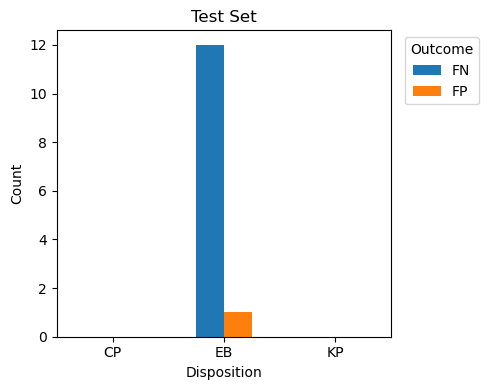

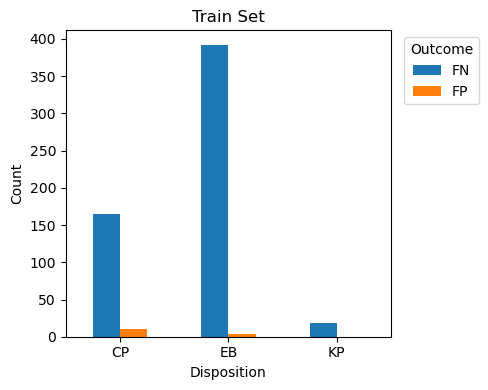

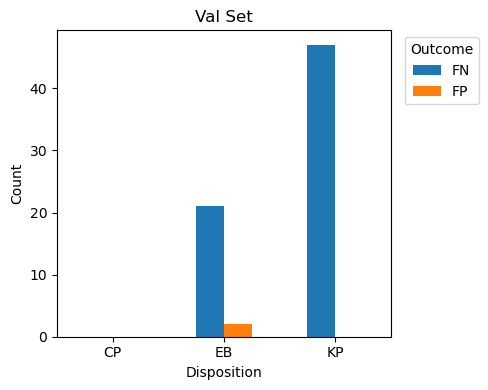

In [8]:
for split, df in summary_df[summary_df['disposition'] != 'ANY'].groupby("split"):
    pivot_split = (
        df.pivot(index="disposition", columns="confusion", values="count")
          .fillna(0)
          .loc[:, ["FN","FP"]]
    )
    fig, ax = plt.subplots(figsize=(5,4))
    pivot_split.plot(kind="bar", stacked=False, ax=ax)
    ax.set_title(f"{split.capitalize()} Set")
    ax.set_xlabel("Disposition")
    ax.set_ylabel("Count")
    ax.legend(title="Outcome", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [72]:
train_preds = all_preds_tbl[all_preds_tbl['split'] == 'train']
train_preds[train_preds['disposition'] == 'KP']['label'].sum()

86

In [68]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['label'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['label'].value_counts())
    false_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")
        

INFO - test set consists of 22481 examples.
INFO - label
1    18889
0     3592
Name: count, dtype: int64
INFO - EB Summary
INFO - Train set consists of 20250 EB examples.
INFO - label
1    18889
0     1361
Name: count, dtype: int64
INFO - CP Summary
INFO - Train set consists of 1088 CP examples.
INFO - label
0    1088
Name: count, dtype: int64
INFO - KP Summary
INFO - Train set consists of 1143 KP examples.
INFO - label
0    1143
Name: count, dtype: int64
INFO - test set has 13 incorrect predictions.
INFO - test has 12 FN examples coming from 2 unique TCEs and 2 unique targets.
INFO - Target list: [193831684 148920245]
INFO - test has 1 FP examples coming from 1 unique TCEs and 1 unique targets.
INFO - Target list: [262758522]
INFO - train set consists of 207557 examples.
INFO - label
1    173578
0     33979
Name: count, dtype: int64
INFO - CP Summary
INFO - Train set consists of 14148 CP examples.
INFO - label
0    13250
1      898
Name: count, dtype: int64
INFO - EB Summary
INFO - Tr

In [ ]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['confusion'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['confusion'].value_counts())
    false_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")
    

INFO - test set consists of 22481 examples.
INFO - confusion
TP    18877
TN     3591
FN       12
FP        1
Name: count, dtype: int64
INFO - EB Summary
INFO - Train set consists of 20250 EB examples.
INFO - confusion
TP    18877
TN     1360
FN       12
FP        1
Name: count, dtype: int64
INFO - CP Summary
INFO - Train set consists of 1088 CP examples.
INFO - confusion
TN    1088
Name: count, dtype: int64
INFO - KP Summary
INFO - Train set consists of 1143 KP examples.
INFO - confusion
TN    1143
Name: count, dtype: int64
INFO - test set has 13 incorrect predictions.
INFO - test has 12 FN examples coming from 2 unique TCEs and 2 unique targets.
INFO - Target list: [193831684 148920245]
INFO - test has 1 FP examples coming from 1 unique TCEs and 1 unique targets.
INFO - Target list: [262758522]
INFO - train set consists of 207557 examples.
INFO - confusion
TP    173003
TN     33964
FN       575
FP        15
Name: count, dtype: int64
INFO - CP Summary
INFO - Train set consists of 14148

# Analyzing Val

In [14]:
example_map = {}
for split_name in ['val', 'test', 'train']:
    logger.info(f"Analyzing split: {split_name}")
    df_split = all_preds_tbl[all_preds_tbl['split'] == split_name]

    # only need FN & FP
    false_examples = {
        'FP': df_split[df_split['confusion'] == 'FP'],
        'FN': df_split[df_split['confusion'] == 'FN']
    }

    example_map[split_name] = {}
    for cf, df_cf in false_examples.items():
        example_map[split_name][cf] = {}
        for t in df_cf['target_id'].unique():
            df_t = df_cf[df_cf['target_id'] == t]
            example_map[split_name][cf][t] = {}
            for tce_uid in df_t['tce_uid'].unique():
                # grab all rows for this target+TCE
                uids = df_t[df_t['tce_uid'] == tce_uid]['uid'].tolist()
                example_map[split_name][cf][t][tce_uid] = uids

        logger.info(f"{split_name} | {cf} Summary:")
        logger.info(df_cf[['pred_label','pred_prob']].describe().to_string())
        logger.info(f"{split_name} | {cf} Unique TCEs: {df_cf['tce_uid'].unique()}")
        logger.info(f"{split_name} | {cf} Unique Targets: {df_cf['target_id'].unique()}")


INFO - Analyzing split: val


INFO - val | FP Summary:
INFO -        pred_label  pred_prob
count         2.0   2.000000
mean          1.0   0.999905
std           0.0   0.000134
min           1.0   0.999810
25%           1.0   0.999857
50%           1.0   0.999905
75%           1.0   0.999952
max           1.0   1.000000
INFO - val | FP Unique TCEs: ['262412046-1-S5']
INFO - val | FP Unique Targets: [262412046]
INFO - val | FN Summary:
INFO -        pred_label  pred_prob
count        68.0  68.000000
mean          0.0   0.114876
std           0.0   0.144853
min           0.0   0.000246
25%           0.0   0.012084
50%           0.0   0.030825
75%           0.0   0.224599
max           0.0   0.491689
INFO - val | FN Unique TCEs: ['138359318-1-S54' '272489351-1-S14-19' '272489351-1-S15'
 '138359318-1-S40' '218821972-1-S12' '274039489-1-S4' '272489351-1-S14']
INFO - val | FN Unique Targets: [138359318 272489351 218821972 274039489]
INFO - Analyzing split: test
INFO - test | FP Summary:
INFO -        pred_label  pred_pr

In [15]:
for info in example_map['val'].items():
    print(info)

('FP', {262412046: {'262412046-1-S5': ['262412046-1-S5_t_1461.8925868476956', '262412046-1-S5_t_1449.724513328493']}})
('FN', {138359318: {'138359318-1-S54': ['138359318-1-S54_t_2775.0173779063653', '138359318-1-S54_t_2772.9800432017646', '138359318-1-S54_t_2793.3533902477698', '138359318-1-S54_t_2777.054712610966', '138359318-1-S54_t_2771.9613758494647', '138359318-1-S54_t_2770.9427084971644', '138359318-1-S54_t_2778.0733799632662', '138359318-1-S54_t_2791.316055543169', '138359318-1-S54_t_2789.278720838569', '138359318-1-S54_t_2787.2413861339683', '138359318-1-S54_t_2784.1853840770673', '138359318-1-S54_t_2776.0360452586656', '138359318-1-S54_t_2781.1293820201668', '138359318-1-S54_t_2785.2040514293676', '138359318-1-S54_t_2773.998710554065', '138359318-1-S54_t_2782.148049372467', '138359318-1-S54_t_2794.37205760007', '138359318-1-S54_t_2780.1107146678664', '138359318-1-S54_t_2788.2600534862686', '138359318-1-S54_t_2790.297388190869', '138359318-1-S54_t_2795.3907249523704', '13835931

In [24]:
nl = '   '
for split in ['train', 'test', 'val']:
    print(f"{nl * 0} {split}")
    for cf in ['FP', 'FN']:
        print(f"{nl * 1} {cf}")
        for target in example_map[split][cf]:
            print(f"{nl * 2} {target}")
            for tce_uid, examples in example_map[split][cf][target].items():
                print(f"{nl * 3} {tce_uid} : {[str(round(float(e.split('_t_')[-1]), 2)) for e in examples]}")
            

print(example_map['train']['FP'])

 train
    FP
       55525572
          55525572-1-S1-36 : ['1535.95']
       267574918
          267574918-1-S14-55 : ['2034.72', '1910.71', '2643.36']
          267574918-1-S14-60 : ['2931.3', '2659.85', '2659.57', '2016.18']
          267574918-1-S14-41 : ['1703.76', '2034.8']
          267574918-1-S14-50 : ['1830.3']
       48507019
          48507019-1-S14-55 : ['1685.31']
       213047427
          213047427-2-S5 : ['1461.51']
       152223725
          152223725-1-S1 : ['1350.96']
       93000166
          93000166-2-S1-65 : ['2315.92']
    FN
       441613385
          441613385-2-S14-26 : ['2032.91', '2031.04', '2033.12', '2034.16', '2033.95']
       136732283
          136732283-1-S55 : ['2802.66', '2815.59']
          136732283-1-S14 : ['1685.23', '1704.6', '1686.52', '1689.1', '1702.02', '1690.39', '1695.56', '1687.81', '1699.44', '1703.31']
       314702305
          314702305-1-S24 : ['1980.55']
       184892124
          184892124-1-S46 : ['2578.0', '2576.02', '2560.15',

In [34]:

splits = ['val', 'test', 'train']
for split in splits:
    df_split = all_preds_tbl[all_preds_tbl['split'] == split]
    for cf in ['FP','FN']:
        df_cf = df_split[df_split['confusion'] == cf]

        # 1) Compute per-(target, tce_uid) mean confidence
        tce_means = (
            df_cf
            .groupby(['target_id','tce_uid'])['pred_prob']
            .mean()
            .rename('tce_avg')
            .reset_index()
        )

        # 2) Compute per-target mean of those tce_uids
        target_means = (
            tce_means
            .groupby('target_id')['tce_avg']
            .mean()
            .rename('target_avg')
            .sort_values(ascending=False)
        )

        print(f"\n=== {split} | {cf} ===")
        for target_id, target_avg in target_means.items():
            print(f"Target {target_id:>10}  ➜  avg prob = {target_avg:.3f}")

            # pull out all the tce's for this target and sort them
            tces = (
                tce_means[tce_means['target_id'] == target_id]
                .set_index('tce_uid')['tce_avg']
                .sort_values(ascending=False)
            )

            for tce_uid, tce_avg in tces.items():
                # list all the underlying uids for context
                uids = (
                    df_cf
                    .loc[
                        (df_cf['target_id']==target_id)&
                        (df_cf['tce_uid']==tce_uid),
                        'uid'
                    ]
                    .tolist()
                )
                print(f"    TCE {tce_uid:>8}  ➜  avg prob = {tce_avg:.3f} from {len(uids)} examples ")


=== val | FP ===
Target  262412046  ➜  avg prob = 1.000
    TCE 262412046-1-S5  ➜  avg prob = 1.000 from 2 examples 

=== val | FN ===
Target  274039489  ➜  avg prob = 0.270
    TCE 274039489-1-S4  ➜  avg prob = 0.270 from 6 examples 
Target  272489351  ➜  avg prob = 0.152
    TCE 272489351-1-S15  ➜  avg prob = 0.226 from 2 examples 
    TCE 272489351-1-S14-19  ➜  avg prob = 0.120 from 5 examples 
    TCE 272489351-1-S14  ➜  avg prob = 0.109 from 3 examples 
Target  218821972  ➜  avg prob = 0.093
    TCE 218821972-1-S12  ➜  avg prob = 0.093 from 5 examples 
Target  138359318  ➜  avg prob = 0.093
    TCE 138359318-1-S54  ➜  avg prob = 0.099 from 23 examples 
    TCE 138359318-1-S40  ➜  avg prob = 0.087 from 24 examples 

=== test | FP ===
Target  262758522  ➜  avg prob = 0.567
    TCE 262758522-1-S7  ➜  avg prob = 0.567 from 1 examples 

=== test | FN ===
Target  148920245  ➜  avg prob = 0.269
    TCE 148920245-1-S1-9  ➜  avg prob = 0.269 from 2 examples 
Target  193831684  ➜  avg prob

In [48]:
def _summarize_tce_examples(tce_uid: str):
    interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    t_tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0]))].copy()
    logger.info(t_tce_tbl_filt[interest_cols])
    
    tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0])) & (tce_tbl['sector_run'] == tce_uid.split('S')[-1].split('_')[0])]
    logger.info(tce_tbl_filt[interest_cols])
    tce_preds_tbl = all_preds_tbl[all_preds_tbl["tce_uid"] == tce_uid].copy()
    logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
    logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Stats by Confusion Label: ")
    for cf in tce_preds_tbl['confusion'].unique():
        logger.info(f"{' ' * 4}{cf} Stats:")
        desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
        logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
    
_summarize_tce_examples("30450412-1-S12")

INFO -                  tce_uid disposition  tce_time0bk  tce_period  tce_duration  \
135994    30450412-1-S12          EB  1625.616250    1.253821      3.335999   
135995    30450412-1-S39          EB  2362.879633    1.253821      3.643031   
186562  30450412-1-S1-39         UNK  1626.189140    5.018293     13.662543   
186563  30450412-2-S1-39         NTP  1628.697004   84.304129      4.500000   
186564  30450412-3-S1-39         NTP  1630.044920   13.515272     15.000000   
186565  30450412-4-S1-39         NTP  1629.053424   27.027145      8.761588   
186566  30450412-5-S1-39         NTP  1632.399780   12.141661     10.500000   
186567  30450412-6-S1-39         NTP  1630.262281   11.254992      3.500000   

        tce_maxmes  tce_maxmesd  
135994    1.500963     0.520833  
135995    1.614725     0.339928  
186562   28.792639     1.802777  
186563    0.000000    42.152065  
186564   67.588593     2.204166  
186565  122.164734     3.211110  
186566   70.323665     1.098611  
186567   

# Looking at average correctness by target and TCE

In [40]:
all_preds_tbl.columns

Index(['uid', 'disposition', 'time', 'label', 'pred_label', 'pred_prob',
       'tw_flag', 'tce_uid', 'target_id', 'confusion', 'mixed_target_flag',
       'tce_depth', 'tce_max_mult_ev', 'tce_maxmes', 'tce_period',
       'tce_duration', 'tce_num_transits', 'split'],
      dtype='object')

In [55]:
splits = ['val','test','train']
for split in splits:
    # 1) select split
    df = all_preds_tbl[all_preds_tbl['split']==split].copy()

    # 2) define correctness: if true_label==1, use pred_prob; else use 1–pred_prob
    df['correctness'] = (
        df['pred_prob'] * df['label'] +
        (1 - df['pred_prob']) * (1 - df['label'])
    )

    # 3) average up to the TCE level
    tce_corr = (
        df
        .groupby(['target_id','tce_uid'])['correctness']
        .mean()
        .rename('tce_corr')
        .reset_index()
    )

    # 4) average those TCE‐means to the target level
    target_corr = (
        tce_corr
        .groupby('target_id')['tce_corr']
        .mean()
        .rename('target_corr')
        .reset_index()
        .sort_values('target_corr', ascending=False)
    )

    # 5) display
    print(f"\n=== Split: {split} — target‐level correctness ===")
    for _, row in target_corr.iterrows():
        print(f"Target {int(row['target_id'])}  ➜  avg correctness = {row['target_corr']:.3f}")



=== Split: val — target‐level correctness ===
Target 229776076  ➜  avg correctness = 1.000
Target 350478924  ➜  avg correctness = 1.000
Target 287669537  ➜  avg correctness = 1.000
Target 298541138  ➜  avg correctness = 1.000
Target 305386053  ➜  avg correctness = 1.000
Target 306987941  ➜  avg correctness = 1.000
Target 307379977  ➜  avg correctness = 1.000
Target 139128537  ➜  avg correctness = 1.000
Target 138430438  ➜  avg correctness = 1.000
Target 318986273  ➜  avg correctness = 1.000
Target 129116176  ➜  avg correctness = 1.000
Target 126446153  ➜  avg correctness = 1.000
Target 327121759  ➜  avg correctness = 1.000
Target 331183881  ➜  avg correctness = 1.000
Target 341679932  ➜  avg correctness = 1.000
Target 122375269  ➜  avg correctness = 1.000
Target 120893542  ➜  avg correctness = 1.000
Target 184008771  ➜  avg correctness = 1.000
Target 349059354  ➜  avg correctness = 1.000
Target 279871974  ➜  avg correctness = 1.000
Target 150443185  ➜  avg correctness = 1.000
Target 1

In [59]:
splits = ['val', 'test', 'train']
for split in splits:
    df = all_preds_tbl[all_preds_tbl['split'] == split].copy()

    for cf in ['FP', 'FN']:
        df_wrong = df[df['confusion'] == cf]

        # Count wrong examples per TCE (target_id + tce_uid)
        tce_counts = (
            df_wrong
            .groupby(['target_id', 'tce_uid'])
            .size()
            .rename('num_wrong_examples')
            .reset_index()
        )

        # Count total wrong examples per target
        target_counts = (
            tce_counts
            .groupby('target_id')['num_wrong_examples']
            .sum()
            .rename('total_wrong_examples')
            .reset_index()
            .sort_values('total_wrong_examples', ascending=False)
        )

        # === DISPLAY per-target ===
        print(f"\n=== Split: {split} | {cf} — total wrong examples per target ===")
        for row in target_counts.itertuples(index=False):
            print(f"Target {int(row.target_id)}  ➜  total wrong = {row.total_wrong_examples}")

        # === DISPLAY per-TCE within target ===
        print(f"\n=== Split: {split} | {cf} — wrong examples per TCE ===")
        tce_counts_sorted = tce_counts.sort_values(['target_id', 'num_wrong_examples'], ascending=[True, False])
        for row in tce_counts_sorted.itertuples(index=False):
            print(f"Target {int(row.target_id)} | TCE {row.tce_uid}  ➜  wrong examples = {row.num_wrong_examples}")



=== Split: val | FP — total wrong examples per target ===
Target 262412046  ➜  total wrong = 2

=== Split: val | FP — wrong examples per TCE ===
Target 262412046 | TCE 262412046-1-S5  ➜  wrong examples = 2

=== Split: val | FN — total wrong examples per target ===
Target 138359318  ➜  total wrong = 47
Target 272489351  ➜  total wrong = 10
Target 274039489  ➜  total wrong = 6
Target 218821972  ➜  total wrong = 5

=== Split: val | FN — wrong examples per TCE ===
Target 138359318 | TCE 138359318-1-S40  ➜  wrong examples = 24
Target 138359318 | TCE 138359318-1-S54  ➜  wrong examples = 23
Target 218821972 | TCE 218821972-1-S12  ➜  wrong examples = 5
Target 272489351 | TCE 272489351-1-S14-19  ➜  wrong examples = 5
Target 272489351 | TCE 272489351-1-S14  ➜  wrong examples = 3
Target 272489351 | TCE 272489351-1-S15  ➜  wrong examples = 2
Target 274039489 | TCE 274039489-1-S4  ➜  wrong examples = 6

=== Split: test | FP — total wrong examples per target ===
Target 262758522  ➜  total wrong = 1

In [62]:
interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
tce_tbl[tce_tbl['target_id'] == 356473034][interest_cols]
# tce_tbl[(tce_tbl['target_id'] == 410418820) & (tce_tbl['sector_run'] == '1-36')][interest_cols]

,tce_uid,disposition,tce_time0bk,tce_period,tce_duration,tce_maxmes,tce_maxmesd
86491,356473034-1-S47,KP,2580.890404,2.615817,2.680865,3.498084,-0.413889
86492,356473034-2-S47,UNK,2580.561874,22.077875,8.573033,3.202702,1.113888
86493,356473034-1-S20,KP,1843.218679,2.615826,2.653041,2.582036,1.472221
86494,356473034-1-S60,KP,2939.264344,2.615715,2.641355,2.868125,1.943055
86495,356473034-1-S14-50,KP,1843.218575,2.615856,2.671989,2.010689,1.556944
86496,356473034-1-S14-60,KP,1843.218969,2.615855,2.715804,1.653828,-0.546875


In [686]:
tce_tbl['disposition'].unique()

array(['UNK', 'NTP', 'CP', 'EB', 'KP', 'FP', 'NEB', 'NPC', 'BD'],
      dtype=object)

In [ ]:
for split_name, preds_tbl in all_preds_tbl.groupby('split'):
    logger.info(f"{split_name} set consists of {len(preds_tbl)} examples.")
    logger.info(preds_tbl['confusion'].value_counts())
    for disp in preds_tbl['disposition'].unique():
        logger.info(f"{disp} Summary")
        disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
        logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
        logger.info(disp_preds_tbl['confusion'].value_counts())
    false_examples = worst_examples = {
        cf : defaultdict(list) for cf in ['FN', 'FP']
    }
    false_examples["FP"] = preds_tbl[preds_tbl["confusion"] == "FP"]
    false_examples["FN"] = preds_tbl[preds_tbl["confusion"] == "FN"]

    logger.info(f"{split_name} set has {len(false_examples['FP']) + len(false_examples['FN'])} incorrect predictions.")
    
    for cf, cf_df in false_examples.items():
        logger.info(f"{split_name} has {len(cf_df)} {cf} examples coming from {len(cf_df['tce_uid'].unique())} unique TCEs and {len(cf_df['target_id'].unique())} unique targets.")
        logger.info(f"Target list: {cf_df['target_id'].unique()}")

In [ ]:
logger.info(f"Train set consists of {len(preds_tbl)} examples.")
logger.info(preds_tbl['confusion'].value_counts())

for disp in preds_tbl['disposition'].unique():
    logger.info(f"{disp} Summary")
    disp_preds_tbl = preds_tbl[preds_tbl['disposition'] == disp].copy()
    logger.info(f"Train set consists of {len(disp_preds_tbl)} {disp} examples.")
    logger.info(disp_preds_tbl['confusion'].value_counts())
worst_examples = {
    cf : defaultdict(list) for cf in preds_tbl["confusion"].unique()
}

num_examples = 200
# Get most confident FP/TN predictions
fp_df = preds_tbl[preds_tbl["confusion"] == "FP"]
worst_examples["FP"] = fp_df.nlargest(num_examples, columns=["pred_prob"])

tn_df = preds_tbl[preds_tbl["confusion"] == "TN"]
worst_examples["TN"] = tn_df.nlargest(num_examples, columns=["pred_prob"])

# Get least confident TP/FN predictions
tp_df = preds_tbl[preds_tbl["confusion"] == "TP"]
worst_examples["TP"] = tp_df.nsmallest(num_examples, columns=["pred_prob"])

fn_df = preds_tbl[preds_tbl["confusion"] == "FN"]
worst_examples["FN"] = fn_df.nsmallest(num_examples, columns=["pred_prob"])


In [ ]:


len(fn_df["target_id"].unique())
logger.info(f"{len(fn_df[fn_df['tw_flag'] < 0])}")
fn_df.describe()
fn_df["mixed"] = fn_df.apply(lambda r: 1 if int(r['target_id']) in mixed_targets else 0, axis=1)

logger.info(f"MIXED FNs: {fn_df['mixed'].sum()}/{len(fn_df)}")

fn_df.head()

In [ ]:

ex_at_mixed_target = {}
for cf, exs_df in worst_examples.items():
    exs_df["mixed_target_flag"] = exs_df.apply(lambda r: 1 if int(r['target_id']) in mixed_targets else 0, axis=1)
    # logger.info(f"{cf}: {exs_df['mixed_target_flag'].sum()} / {} are mixed")

In [ ]:
len(worst_examples["FN"]["target_id"].unique())

In [ ]:
# worst_examples["FP"]["target_id"].unique()
worst_examples["FN"][20:40]#["target_id"].unique()

In [ ]:

worst_targets_set = set([])
worst_targets_list = []
worst_targets_map = defaultdict(list)
for _, fn in worst_examples["FN"].iterrows():
    logger.info(f"{fn['target']}, {fn['uid']}, {fn['pred_prob']}")
    worst_targets_set.add(fn['target'])
    worst_targets_list.append(fn['target'])
    worst_targets_map[fn['target']].append(fn['uid'])


In [ ]:
len(worst_targets_set)


In [ ]:
for t, exs in worst_targets_map.items():
    logger.info(f"{t}: {len(exs)} {'mixed' if int(t) in mixed_targets else ''}")

In [ ]:
worst_targets_map["358232450"]

In [ ]:
interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
tce_tbl[tce_tbl['target_id'] == 358232450][interest_cols]
# tce_tbl[(tce_tbl['target_id'] == 410418820) & (tce_tbl['sector_run'] == '1-36')][interest_cols]

In [ ]:
def _summarize_tce_examples(tce_uid: str):
    interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    t_tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0]))].copy()
    logger.info(t_tce_tbl_filt[interest_cols])
    
    tce_tbl_filt = tce_tbl[(tce_tbl['target_id'] == int(tce_uid.split('-')[0])) & (tce_tbl['sector_run'] == tce_uid.split('S')[-1].split('_')[0])]
    logger.info(tce_tbl_filt[interest_cols])
    tce_preds_tbl = preds_tbl[preds_tbl["tce_uid"] == tce_uid].copy()
    logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
    logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
    logger.info(f"Stats by Confusion Label: ")
    for cf in tce_preds_tbl['confusion'].unique():
        logger.info(f"{' ' * 4}{cf} Stats:")
        desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
        logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
    
_summarize_tce_examples("189476500-1-S1-36")

In [ ]:
def _summarize_target_examples(target_id: str):    
    target_preds_tbl = preds_tbl[preds_tbl["target_id"] == int(target_id)].copy()
    logger.info(f"Dataset has {len(target_preds_tbl)} examples corresponding to {target_id}\n")
    for tce_uid in target_preds_tbl["tce_uid"].unique():
        tce_preds_tbl = target_preds_tbl[target_preds_tbl["tce_uid"] == tce_uid].copy()
        logger.info(f"Dataset has {len(tce_preds_tbl)} examples corresponding to {tce_preds_tbl['disposition'].unique()[0]}, {tce_uid} ")
        logger.info(f"Confusion counts: \n {textwrap.indent(tce_preds_tbl['confusion'].value_counts().to_string(), ' ' * 4)}")
        logger.info(f"Transit Window Counts: \n {textwrap.indent(tce_preds_tbl['tw_flag'].value_counts().to_string(), ' ' * 4)}")
        logger.info(f"Stats by Confusion Label: ")
        for cf in tce_preds_tbl['confusion'].unique():
            logger.info(f"{' ' * 4}{cf} Stats:")
            desc = tce_preds_tbl[tce_preds_tbl['confusion'] == cf]['pred_prob'].describe()[1:]
            logger.info(f"{textwrap.indent(desc.to_string(), ' ' * 8)}")
        

_summarize_target_examples('4164713')

In [ ]:
temp_df = preds_tbl[preds_tbl["target_id"] == 189476500]
temp_df[temp_df['confusion'] == 'FP'][['uid', 'confusion', 'pred_prob']]

In [ ]:
def _logger.info_tce_preds(tce_uid):
    # interest_cols = ['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']
    preds_tbl_filt = preds_tbl[preds_tbl['tce_uid'] == tce_uid].copy()
    for _, ex in preds_tbl_filt.iterrows():
        if float(ex['time']) > 2899 and float(ex['time']) < 2900:
            logger.info(ex[['uid', 'confusion', 'disposition', 'label', 'pred_prob']])

_logger.info_tce_preds('388431711-4-S14-60')
_logger.info_tce_preds('388431711-1-S14-60')


In [ ]:
# Comparing Examples

tce_tbl[(tce_tbl['tce_uid'] == '148158540-3-S11') | (tce_tbl['tce_uid'] == '148158540-1-S11')][['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd']]

In [ ]:
tce_tbl[(tce_tbl['tce_uid'] == '26489741-1-S40')][['tce_uid', 'disposition', 'tce_time0bk','tce_period', 'tce_duration', 'tce_maxmes', 'tce_maxmesd', 'tec_fluxtriage_comment']]


In [ ]:
def mean_maxmes_by_target(df):
    return df.groupby('target_id')['maxmes'].mean().dropna()


In [ ]:
eb = tce_tbl[tce_tbl['disposition'] == 'EB']
cp = tce_tbl[tce_tbl['disposition'] == 'CP']
kp = tce_tbl[tce_tbl['disposition'] == 'KP']
combined = tce_tbl[tce_tbl['disposition'].isin(['EB', 'CP', 'KP'])]

for name, df in [('EB', eb), ('CP', cp), ('KP', kp), ('ALL', combined)]:
    plt.figure()
    data = df['tce_maxmes'].dropna()
    plt.hist(data, bins=100)
    plt.title(f'Distribution of maxmes for {name} TCEs')
    plt.xlabel('maxmes')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.xlim((0,data.quantile(0.99) ))
    plt.show()
    

# OLD

In [ ]:

tce_uid = "188768068-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'

examples_tce = preds_tbl.loc[preds_tbl["tce_uid"] == tce_uid]
disp_tce = examples_tce["disposition"].values[0]
mes_tce = examples_tce["tce_max_mult_ev"].values[0]

transit_window_examples = examples_tce.loc[examples_tce["label"] == 1]
not_transit_window_examples = examples_tce.loc[examples_tce["label"] == 0]

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    transit_window_examples["time"],
    transit_window_examples["pred_prob"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Transit Window Examples",
)
ax.scatter(
    not_transit_window_examples["time"],
    not_transit_window_examples["pred_prob"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Not-Transit Window Examples",
)
ax.set_ylabel("Model Score")
ax.set_xlabel("Timestamp [BTJD]")
ax.set_ylim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"scatter_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


bins_scores = np.linspace(0, 1, 11)

f, ax = plt.subplots()
ax.hist(
    transit_window_examples["pred_prob"],
    bins_scores,
    histtype="step",
    label="Transit Window Examples",
)
ax.hist(
    not_transit_window_examples["pred_prob"],
    bins_scores,
    histtype="step",
    label="Not-Transit Window Examples",
)
ax.set_xlabel("Model Score")
ax.set_ylabel("Example Count")
ax.set_xlim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"hist_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


In [ ]:

tce_uid =  "188768068-1-S14-26" #"352954787-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'
lc_dir = Path("/Users/jochoa4/Downloads/")
sector_arr = list(range(14, 27))


tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

# find light curve data for target
search_lc_res = lk.search_lightcurve(
    target=f"tic{tce['target_id'].values[0]}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_arr,
)

lcf = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)


def lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
    lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
    return lcf.normalize()


lcf = lcf.stitch(corrector_func=lcf_masked_quantity_corrector)


In [ ]:
lcf

In [ ]:

t0, win_label = 1966.07, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [ ]:
tfrec_fp = Path("/Users/jochoa4/Desktop/study_transfers/study_model_preds_05-22-2025/tfrecords/norm_train_shard_2990-8611.tfrecord")


t0, win_label = 1966.07, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [ ]:

tce_uid = "161687311-2-S24"

examples_tce = preds_tbl.loc[preds_tbl["tce_uid"] == tce_uid]
disp_tce = examples_tce["disposition"].values[0]
mes_tce = examples_tce["tce_max_mult_ev"].values[0]

transit_window_examples = examples_tce.loc[examples_tce["label"] == 1]
not_transit_window_examples = examples_tce.loc[examples_tce["label"] == 0]

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(
    transit_window_examples["time"],
    transit_window_examples["raw_pred"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Transit Window Examples",
)
ax.scatter(
    not_transit_window_examples["time"],
    not_transit_window_examples["raw_pred"],
    s=8,
    alpha=0.3,
    edgecolors="k",
    label="Not-Transit Window Examples",
)
ax.set_ylabel("Model Score")
ax.set_xlabel("Timestamp [BTJD]")
ax.set_ylim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"scatter_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


bins_scores = np.linspace(0, 1, 11)

f, ax = plt.subplots()
ax.hist(
    transit_window_examples["raw_pred"],
    bins_scores,
    histtype="step",
    label="Transit Window Examples",
)
ax.hist(
    not_transit_window_examples["raw_pred"],
    bins_scores,
    histtype="step",
    label="Not-Transit Window Examples",
)
ax.set_xlabel("Model Score")
ax.set_ylabel("Example Count")
ax.set_xlim(bins_scores[[0, -1]])
ax.legend()
ax.set_title(
    f"TCE {tce_uid}\nDisposition {disp_tce}\nNumber of examples"
    f" {len(examples_tce)} | TCE Max MES {mes_tce:.3f}"
)
f.tight_layout()
f.savefig(
    plot_dir / f"hist_transit_nottransit_examples_scores_{tce_uid}_{disp_tce}.png"
)
plt.show()


In [ ]:

tce_uid =  "161687311-2-S24" #"352954787-1-S14-26"  # "198408416-1-S14-60"  # '425064757-1-S1-65'   # '198408416-1-S14-60'
lc_dir = Path("/Users/jochoa4/Downloads/")
sector_arr = list(range(24, 25))


tce = tce_tbl.loc[tce_tbl["tce_uid"] == tce_uid]

# find light curve data for target
search_lc_res = lk.search_lightcurve(
    target=f"tic{tce['target_id'].values[0]}",
    mission="TESS",
    author=("TESS-SPOC", "SPOC"),
    exptime=120,
    cadence="long",
    sector=sector_arr,
)

lcf = search_lc_res.download_all(
    download_dir=str(lc_dir), quality_bitmask="default", flux_column="pdcsap_flux"
)


def lcf_masked_quantity_corrector(lcf: lk.LightCurve) -> lk.LightCurve:
    lcf = lk.LightCurve({"time": lcf.time.value, "flux": np.array(lcf.flux.value)})
    return lcf.normalize()


lcf = lcf.stitch(corrector_func=lcf_masked_quantity_corrector)


In [ ]:

t0, win_label = 1970.34, 1 #1696.34, 0  # 2425.47, 0  # 2424.57, 1

dur_f = 5
win_len = tce["tce_duration"].values[0] / 24 * dur_f

t_start, t_end = t0 - win_len / 2, t0 + win_len / 2

f, ax = plt.subplots()
lcf.plot(ax=ax)
ax.set_xlim([t_start, t_end])
ax.set_title(f"TCE {tce_uid} | Disposition {disp_tce}\nt0={t0} | Label {win_label}")
f.savefig(plot_dir / f"plot_{tce_uid}_{disp_tce}_timestamp{t0}_label{win_label}.png")


In [682]:
tce_tbl[tce_tbl['tce_uid'] == '250386181-1-S30'][interest_cols]

,tce_uid,disposition,tce_time0bk,tce_period,tce_duration,tce_maxmes,tce_maxmesd
125498,250386181-1-S30,EB,2116.67134,1.470232,1.399317,2.269011,0.953403


In [685]:
for col in tce_tbl.columns:
    if 'master' in col:
        print(col)